In [1]:
import pandas as pd
import numpy as np
import os 
import cv2
from skimage.io import ImageCollection
from skimage.io import imread,imshow
from utils_fcn import DataGeneratorMobileNet
import matplotlib.pyplot as plt
import keras.callbacks
%matplotlib inline

/home/wvillegas/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dataset = pd.read_csv(os.path.join('/home','wvillegas','dataset-mask', 'full_masks.csv'))

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset['orig'],dataset['mask'],
                                                    test_size = 0.2, random_state=1)

In [5]:
partition = {'train':list(X_train),
             'test': list(X_test)}

In [6]:
img_list = list(X_train) + list(X_test)
mask_list = list(Y_train) + list(Y_test)

In [7]:
labels = dict(zip(img_list, mask_list))

In [8]:
img_path = os.path.join('/home','wvillegas','dataset-mask','dataset_resize', 'images_resize')
masks_path = os.path.join('/home','wvillegas','dataset-mask','dataset_resize', 'masks_resize')

In [9]:
batch_size = 4

In [10]:
train_generator = DataGeneratorMobileNet(batch_size=batch_size,img_path=img_path,
                                labels=labels,list_IDs=partition['train'],n_channels=3,
                                n_channels_label=1,shuffle=True,mask_path=masks_path)
valid_generator = DataGeneratorMobileNet(batch_size=batch_size,img_path=img_path,
                                labels=labels,list_IDs=partition['test'],n_channels=3,
                                n_channels_label=1,shuffle=True,mask_path=masks_path)

In [11]:
from keras.applications import MobileNet
from keras.layers import Conv2DTranspose,Conv2D, activations
from keras import Model
from keras.models import load_model

In [12]:
net = MobileNet(include_top=False, weights=None)

In [13]:
net.load_weights('/home/wvillegas/DLProjects/BudClassifier/cmdscripts/modelosV2/mobilenet_weights_detection.h5', by_name=True)

In [14]:
for layer in net.layers:
    layer.trainable = True

In [15]:
# test arquitectura paper de FCN 
# deconv1 = Conv2D(filters=256,kernel_size=3,strides=1,activation='relu')(mobilenet.output)
predict = Conv2D(filters=1,kernel_size=1,strides=1, activation='relu')(net.output)
deconv32 = Conv2DTranspose(filters=1,kernel_size=64,strides=32, padding='same', activation='sigmoid')(predict)


In [16]:
fcn = Model(inputs=net.input,outputs=deconv32)

In [17]:
from keras.optimizers import SGD, RMSprop

In [18]:
sgd = SGD(lr=0.001,momentum=0.9)
fcn.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [19]:
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=3, min_lr=0.00001)

In [20]:
history = fcn.fit_generator(generator=train_generator,validation_data=valid_generator,
                            use_multiprocessing=True,workers=6, epochs=10)

Epoch 1/10
148/148 [==============================] - 130s 875ms/step - loss: 0.5618 - acc: 0.9476 - val_loss: 0.4398 - val_acc: 0.9969
Epoch 2/10
148/148 [==============================] - 118s 795ms/step - loss: 0.3644 - acc: 0.9971 - val_loss: 0.3011 - val_acc: 0.9968
Epoch 3/10
148/148 [==============================] - 118s 795ms/step - loss: 0.2607 - acc: 0.9971 - val_loss: 0.2240 - val_acc: 0.9968
Epoch 4/10
148/148 [==============================] - 119s 804ms/step - loss: 0.2005 - acc: 0.9970 - val_loss: 0.1761 - val_acc: 0.9977
Epoch 5/10
148/148 [==============================] - 118s 798ms/step - loss: 0.1614 - acc: 0.9972 - val_loss: 0.1461 - val_acc: 0.9975
Epoch 6/10
148/148 [==============================] - 119s 802ms/step - loss: 0.1339 - acc: 0.9976 - val_loss: 0.1256 - val_acc: 0.9965
Epoch 7/10
148/148 [==============================] - ETA: 0s - loss: 0.1146 - acc: 0.997 - 118s 798ms/step - loss: 0.1145 - acc: 0.9977 - val_loss: 0.1038 - val_acc: 0.9974
Epoch 8/10

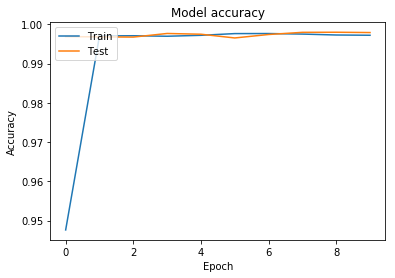

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

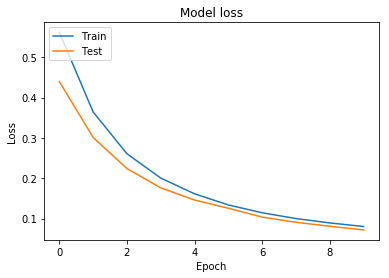

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
list_img = partition['test'][0:11]

In [24]:
inp_img = []
for img in list_img:
    temp = cv2.imread(img_path + '/' + img)
    temp = cv2.resize(temp, (0,0), fx=0.5, fy=0.5)
    temp = cv2.normalize(temp, temp, 0, 255, cv2.NORM_MINMAX)
    inp_img.append(temp)
    
ground_truth = []
for img in list_img:
    mask = labels[img]
#     print(mask)
    temp = cv2.imread(masks_path + '/' + mask)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    temp = temp.astype(bool).astype(int)
    ground_truth.append(temp)


In [25]:
inp_img = np.asarray(inp_img)
ground_truth = np.asarray(ground_truth)

In [26]:
pred = fcn.predict(inp_img)

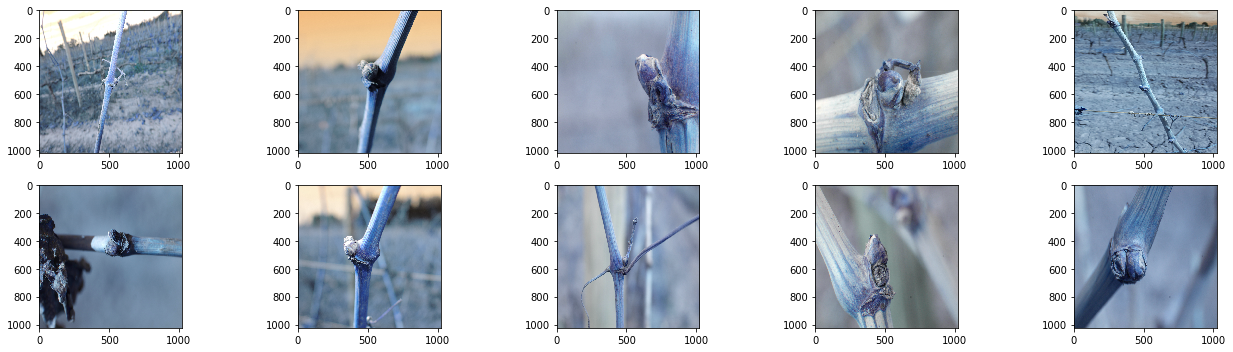

In [27]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = inp_img[i-1,:,:,:]
    fig.add_subplot(rows, columns, i)
    imshow(img)
plt.show()

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


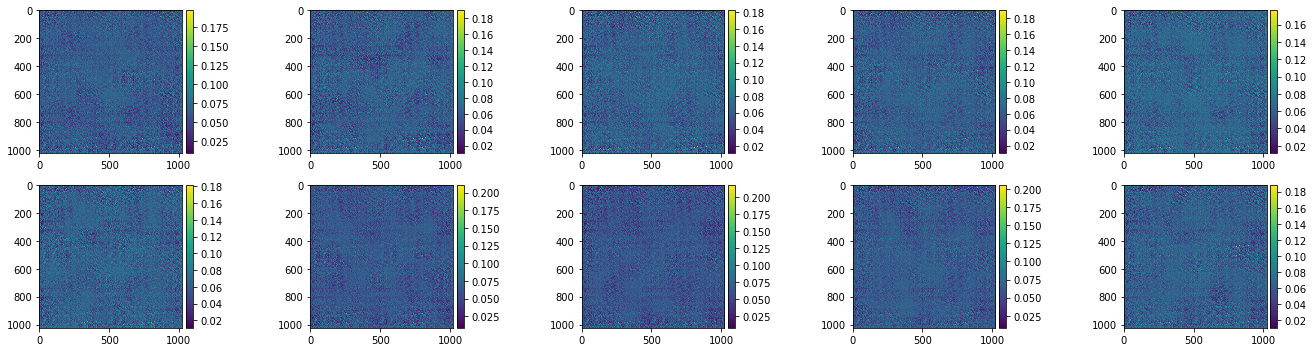

In [28]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = pred[i-1,:,:,0]
    fig.add_subplot(rows, columns, i)
#     plt.gray()
    imshow(img)
plt.show()

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


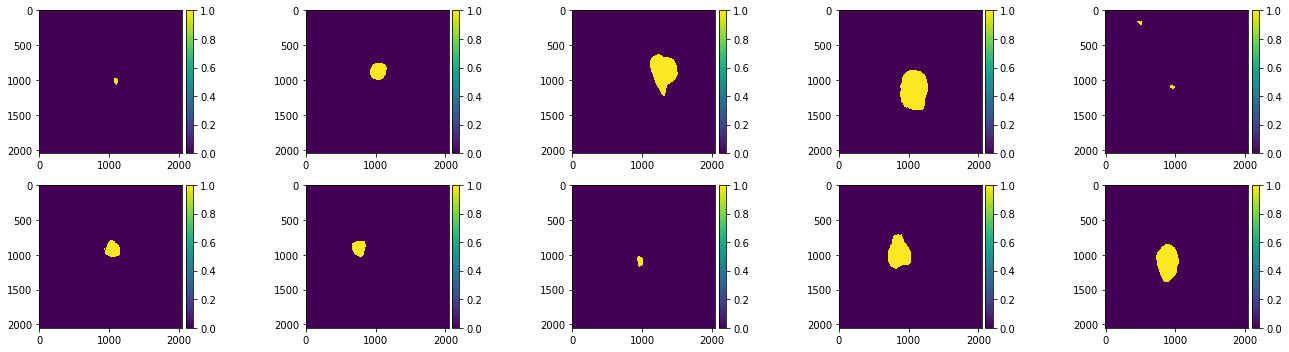

In [29]:
fig=plt.figure(figsize=(20, 5))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = ground_truth[i-1,:,:]
    fig.add_subplot(rows, columns, i)
    imshow(img)
plt.show()

Now we compute the IoU for each test sample

In [30]:
test_iou = {
    'sample':[],
    'iou':[],
}

In [31]:
# for test_sample in partition['test']:
#     test_iou['sample'].append(test_sample)
#     sample = cv2.imread(img_path + '/' + test_sample)
# #   sample = cv2.resize(sample, (0,0), fx=0.5, fy=0.5)
#     print('lol')
#     sample = cv2.normalize(sample, sample, 0, 255, cv2.NORM_MINMAX)
#     sample = np.expand_dims(sample, axis=0)
#     prediction = fcn.predict(sample)
#     #apply threshold
#     prediction = (prediction > 0)
#     mask_name = labels[test_sample]
#     mask = cv2.imread(masks_path + '/' + mask_name)
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     mask = mask.astype(bool).astype(int)
#     #compute iou
#     iou = np.sum(np.logical_and(prediction, mask)) / np.sum(np.logical_or(prediction, mask))
#     test_iou['iou'].append(iou)